In [ ]:
import matplotlib.pyplot as plt
import torch
import math
from PIL import Image
import matplotlib.animation as animation
from concurrent.futures import ThreadPoolExecutor
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

from experiment.parameters import ExperimentParams
from data.sampler import VideoSampler
from models.video_model import VideoModel
import names


# Notebook Visualisations

This Jupyter notebook is structured into five main sections, each performing a specific task in the data analysis and visualisation process. Here's a brief overview of each section:

1. Specify target experiment
2. Load data and generate predictions
3. Convert class predictions into class probabilities
4. Visualise results: 
  - Confusion matrices for classification tasks
  - Time series plots for regression tasks
5. Generate a video animation

## 1. Specify target experiment

In [2]:
sub_folder = 'Exp1_M04_Video_All_tasks_Fusion_inputs_20240314_220638_6f0ffda6'
predictions_file = f'{names.TEST_IDS[0]}_predictions'
ids_list= [names.TEST_IDS[0]]

## 2. Load data and generate predictions

Here, we load the necessary data for our experiment from a local file. We also generate predictions using our specified model. If the predictions have already been generated and saved to disk, we can load them directly.

#### *If predictions have already been generated*

In [3]:
# data is a dictionary with keys inputs, predictions, targets, classification_tasks, regression_tasks
def load_data(sub_folder, predictions_file):
    data = torch.load(os.path.join(names.MODELS_DIR, sub_folder, names.RESULTS_DIR, f'{predictions_file}.pt'), map_location=torch.device('cpu'))
    return data

In [4]:
# Load data if needed
data = load_data(sub_folder, predictions_file)

#### *If predictions have not been generated*

In [ ]:
exp = ExperimentParams.load_from_subfolder(sub_folder=sub_folder)
sampler = VideoSampler(exp)
model = VideoModel(exp)

In [ ]:
# Choose model: BEST or LAST
model.load_state(version=names.BEST_MODEL) 

In [ ]:
# Run inference and generate predictions  
batch_size = 4
stride = 1
inputs, labels = sampler.sample_inference_sequences(overrides={'stride' : stride, 'batch_size':batch_size}, unique_id_list=ids_list)
data = model.predict(inputs, labels, save_predictions_as=predictions_file)

## 3. Convert class predictions into probabilities

In this section, we convert the raw class predictions from our model into class probabilities. This is particularly useful for probabilistic models and can provide additional insight into the model's confidence in its predictions.

In [5]:
def process_predictions(data):
    class_labels = {}
    class_predictions = {}
    class_probs = {}

    n = 0
    for i, (name, num_classes) in enumerate(data['classification_tasks'].items()):
        if num_classes == 2:
            labels = data['targets'][:, 0, i]

            logits = data['predictions'][:, 0, n]
            probs = {1: torch.sigmoid(logits)}
            probs[0] = 1 - probs[1]
            task_predictions = (logits > 0).long() # Predict class 1 if the output is greater than 0
            n += 1
        else:
            labels = data['targets'][:, 0, i]

            logits = data['predictions'][:, 0, n:n+num_classes]
            probs = {i: torch.softmax(logits, dim=1)[:, i] for i in range(num_classes)}
            task_predictions = torch.argmax(logits, dim=1)
            n += num_classes

        class_labels[name] = labels
        class_predictions[name] = task_predictions
        class_probs[name] = probs

    return class_labels, class_predictions, class_probs

In [6]:
class_labels, class_predictions, class_probs = process_predictions(data)

## 4a. Confusion matrix for classification tasks

Here, we generate confusion matrices for our classification tasks. This provides a visual representation of how well our model is performing, highlighting where it's making correct predictions and where it's making mistakes.

In [46]:
def plot_cm(labels, predictions):
    num_tasks = len(predictions)
    num_cols = 2 
    num_rows = (num_tasks + num_cols - 1) // num_cols 

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(9, num_rows * 4.5))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(bottom=0.2)  # Adjust the bottom to create space for annotations

    if num_tasks <= num_cols:
        axs = axs.flatten()
    else:
        axs = axs.ravel()

    for i, task in enumerate(predictions):
        true_labels = labels[task]
        pred_labels = predictions[task]

        num_classes = len(torch.unique(true_labels))
        
        cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))
        precision, recall, _, _ = precision_recall_fscore_support(true_labels, pred_labels, labels=range(num_classes), zero_division=0)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
        disp.plot(ax=axs[i], cmap=plt.cm.Greys)
        axs[i].set_title(f'Confusion Matrix for {task}')

        cell_width = 1 / num_classes
        for class_idx, (class_precision, class_recall) in enumerate(zip(precision, recall)):
            x_pos = cell_width/2 + class_idx*cell_width
            axs[i].annotate(f'Precision: {class_precision:.2f}', 
                            xy=(x_pos, 0), xycoords='axes fraction',
                            xytext=(0, -40), textcoords='offset points',
                            ha='center', va='top', fontsize=9)
            axs[i].annotate(f'Recall: {class_recall:.2f}', 
                            xy=(x_pos, 0), xycoords='axes fraction',
                            xytext=(0, -55), textcoords='offset points',
                            ha='center', va='top', fontsize=9)
        
    for idx in range(num_tasks, num_rows * num_cols):
        axs[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

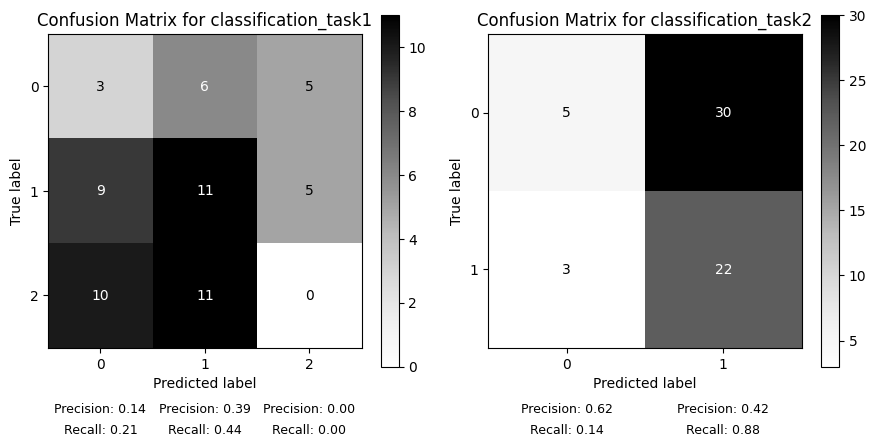

In [47]:
plot_cm(class_labels, class_predictions)

## 4b. Time series plots for regression tasks

For regression tasks, we plot the actual values against the predicted values over time. This helps us understand how well our model is predicting continuous values.

In [48]:
num_class_outputs = sum([1 if n == 2 else n for n in data['classification_tasks'].values()])
num_class_tasks = len(data['classification_tasks'])
num_targets = len(data['regression_tasks'])

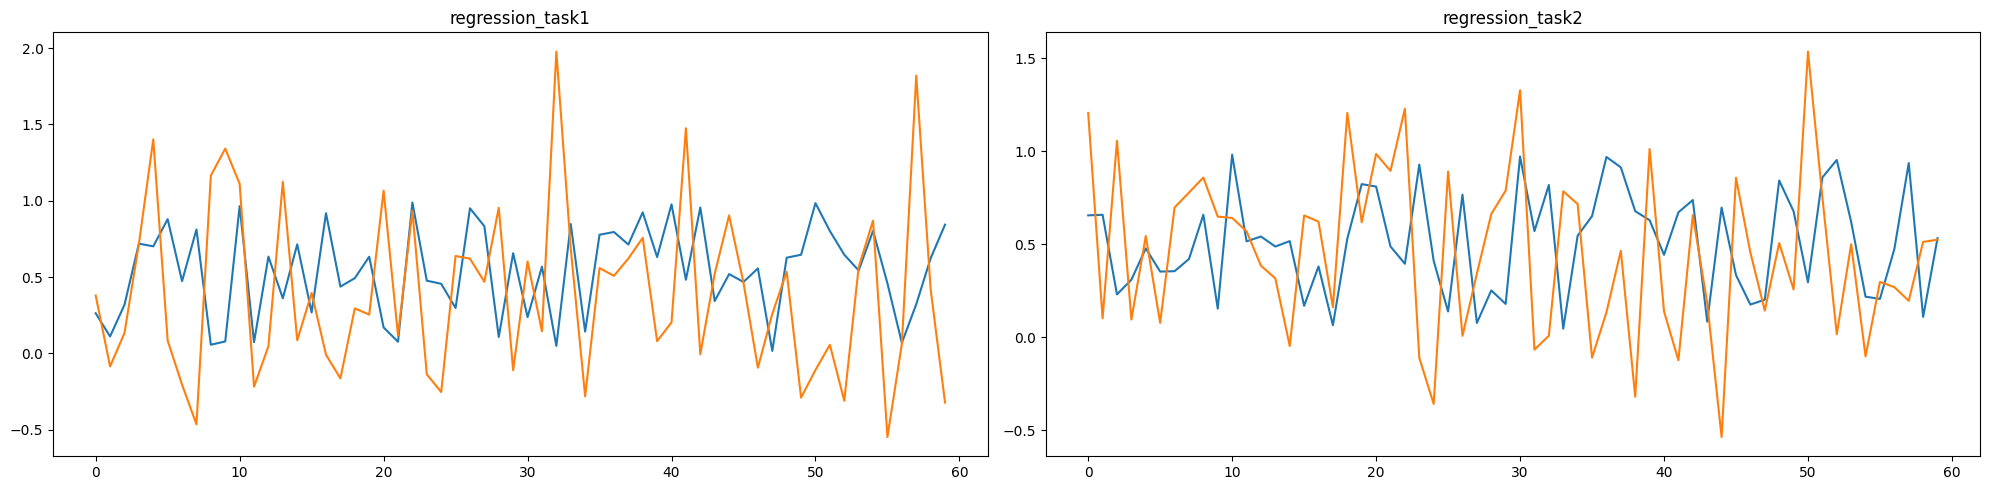

In [49]:
if num_targets > 0:
    num_cols = 2 
    num_rows = math.ceil(num_targets / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Adjust the figure size as needed
    fig.patch.set_facecolor('white')
    axs = axs.flatten()

    for i in range(num_targets):
        axs[i].plot(data['targets'][:, 0, num_class_tasks+i])
        axs[i].plot(data['predictions'][:, 0, num_class_outputs+i])
        axs[i].set_title(data['regression_tasks'][i])

    # Remove any unused subplots
    for i in range(num_targets, num_rows * num_cols):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.savefig(os.path.join(names.MODELS_DIR, sub_folder, names.RESULTS_DIR, f'{predictions_file}.png'))
    plt.show()

## 5. Generate video with class probabilities

Finally, we generate a video animation that shows the class probabilities over time, aligned with the actual class labels. This provides a dynamic view of how the model's predictions evolve over time.

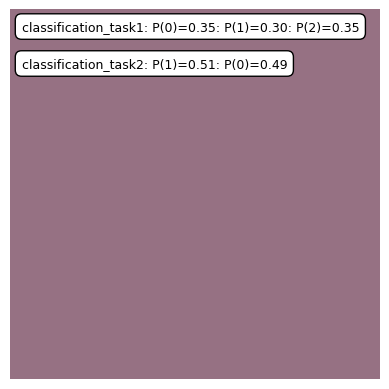

In [8]:
def load_images_batch(image_paths):
    return [np.array(Image.open(image_path)) for image_path in image_paths]

# Function to load images in batches
image_paths = data['inputs'][names.IMAGES][:, -1].tolist()

# Define the number of threads and batch size
num_threads = 1  # Adjust this based on your system
batch_size = len(image_paths) // num_threads

# Load images in parallel in batches
preprocessed_images = []
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        preprocessed_images.extend(executor.submit(load_images_batch, batch).result())

# Optimize the animate function
def animate(i):
    ax.clear()
    img = preprocessed_images[i]
    # height, width, _ = img.shape

    # Overlay the gaze point on the image
    # img_with_gaze = cv2.circle(img, (gaze_point_x, gaze_point_y), radius=5, color=(255, 0, 0), thickness=-1)
    ax.imshow(img)
    ax.axis('off')
    for j, (name, probs) in enumerate(class_probs.items()):
        label = ': '.join([name] + [f"P({c})={p[i]:.2f}" for c, p in probs.items()])
        ax.annotate(label, 
                    xy=(0.05,1-0.01-0.1*j), xycoords='axes fraction', 
                    xytext=(-5, -5), textcoords='offset points',
                    ha='left', va='top', fontsize=9,
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, animate, frames=len(image_paths), interval=66)
ani.save(os.path.join(names.MODELS_DIR, sub_folder, names.RESULTS_DIR, names.ANIMATION), writer='ffmpeg')
plt.show()